# Анализ поведения пользователей мобильного приложения

## Описание проекта
- Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.
- Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.
- Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.
- В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

## Описание данных
Каждая запись в логе — это действие пользователя, или событие.
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
#Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import math as mth
from scipy import stats as st

In [2]:
#Считаем датасет 
path = '/datasets/'
df = pd.read_csv(path + 'logs_exp.csv', sep='\t')
# Посмотрим данные
df.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


#### В датасете имеются столбцы с названием события, ID пользователя, временем события и номером экспериментальной группы. Дата записана в неправильном формате. Видны такие события: 'Появление главного экрана', 'Появление экрана оплаты' и т д. События являются частью воронки продаж на сайте.

## Шаг 2. Подготовьте данные

### 1) Заменим названия столбцов на удобные

In [3]:
df.columns = ['event_name', 'device_id', 'datetime', 'experiment_id']

### 2) Проверим пропуски и типы данных. Откорректируем при необходимости

In [4]:
#Посмотрим общую информацию о таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
event_name       244126 non-null object
device_id        244126 non-null int64
datetime         244126 non-null int64
experiment_id    244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
# Откорректируем типы данных
df['datetime'] = pd.to_datetime(df['datetime'], unit='s')
df['device_id'] = df['device_id'].astype(str)
df['experiment_id'] = df['experiment_id'].astype(str)

In [6]:
# Проверим наличие дубликатов
df.duplicated().sum()

413

In [7]:
# Удалим дубликаты
df = df.drop_duplicates()

### 3) Добавим столбец даты и времени, а также отдельный столбец дат

In [8]:
df['date'] = df['datetime'].dt.date

#### В таблицу были удалены дубликаты, откорректированы типы данных, добавлен столбец с данной. Пропуски в таблице отсутствуют

## Шаг 3. Изучите и проверьте данные

### 1) Сколько всего событий в логе?

In [9]:
print('В логе всего', len(df['event_name'].value_counts()), 'вариантов событий')

В логе всего 5 вариантов событий


In [10]:
print('Всего событий в логе', len(df['event_name']))

Всего событий в логе 243713


In [11]:
# Посмотрим на количество событий каждого вида
df['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

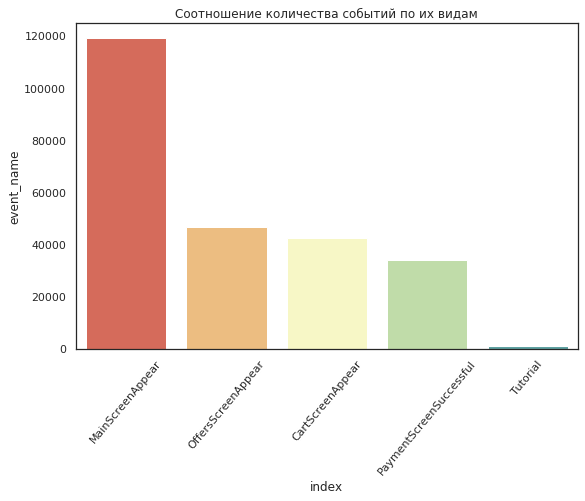

In [12]:
# Дополнительно визуализируем таблицу в виде столбчатых диаграмм
sns.set(style='white')
plt.figure(figsize=(9, 6))
plt.title('Соотношение количества событий по их видам')

sns.barplot(x='index',y='event_name', data=df['event_name'].value_counts().reset_index(), palette='Spectral')
plt.xticks(rotation=50) 

#### В логе есть 5 событий, по убыванию их популярности: показ пользователю главного экрана, показ экрана с предложением, показ экрана корзины, показ экрана с подтверждением оплаты, показ обучения

### 2) Сколько всего пользователей в логе?

In [13]:
print('В логе всего', len(df['device_id'].value_counts()), 'пользователь')

В логе всего 7551 пользователь


### 3) Сколько в среднем событий приходится на пользователя?

In [14]:
df_events = df.pivot_table(index='device_id',values='event_name',aggfunc='count')
print('В среднем на пользователя приходится', round(df_events['event_name'].mean(), 1), 'события')

В среднем на пользователя приходится 32.3 события


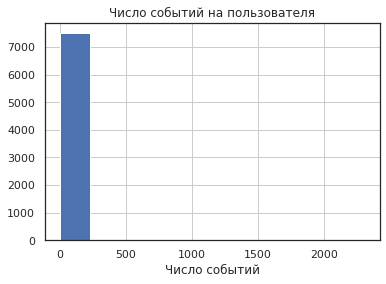

In [15]:
# Визуализируем
df_events['event_name'].hist().set_title('Число событий на пользователя')
plt.xlabel("Число событий")
plt.show()

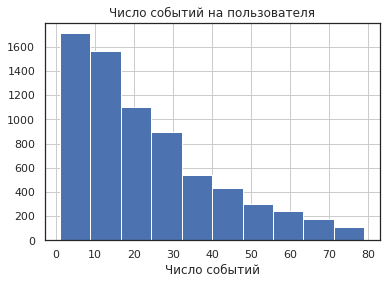

In [16]:
# Откинем выбросы
df_events.query('event_name < 80')['event_name'].hist().set_title('Число событий на пользователя')
plt.xlabel("Число событий")
plt.show()

#### В среднем на пользователя приходится 32 события, однако это число завышено из за больших выбросов. Чаще всего на пользователей приходится 0-30 событий.

### 4) Данными за какой период мы располагаем? Найдем максимальную и минимальную дату. Построим гистограмму по дате и времени. Можно ли быть уверенными, что у нас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определим, с какого момента данные полные и отбросим более старые. Данными за какой период времени мы располагаем на самом деле?

In [17]:
print('Минимальная дата', df['date'].min())
print('Максимальная дата', df['date'].max())

Минимальная дата 2019-07-25
Максимальная дата 2019-08-07


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


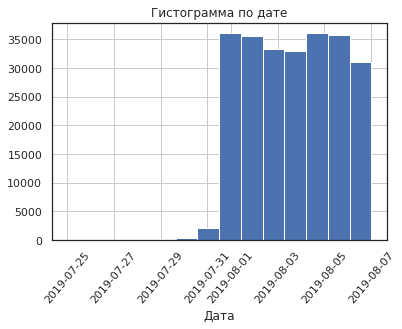

In [18]:
# Посмотрим гистограмму  событий по дате
df['date'].hist(bins = 14).set_title('Гистограмма по дате')
plt.xlabel("Дата")
plt.xticks(rotation=50) 
plt.show()

<div class="alert alert-success">
<h2> Комментарий ревьюера </h2>
    
Обрати внимание на предупреждение, которое появилось при построение графика. Чтобы его избежать нужно добавить следующие строчки перед построением:

- from pandas.plotting import register_matplotlib_converters
- register_matplotlib_converters()

На данный момент, это не обязательно, код отработает и без них. Но в будущих версиях, когда будет необходимость вызвать конвертер типов данных, эти строчки будут обязательны.
</div>

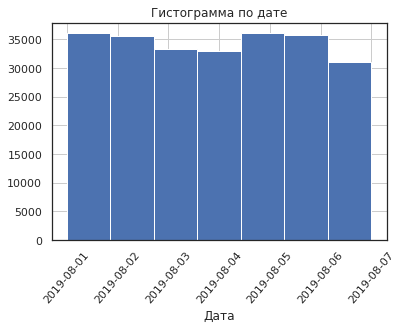

In [19]:
# Посмотрим гистограмму  событий по дате, начиная с 01.08.2019
df['date'] = pd.to_datetime(df['date'])
df_new_data = df.query('date > "2019-07-31"')
df_new_data['date'].hist(bins = 7).set_title('Гистограмма по дате')
plt.xlabel("Дата")
plt.xticks(rotation=50) 
plt.show()

#### По гистограмме видно, что до 01.08.201 совершается очень мало событий. Скорее всего как раз с этой даты все данные доехали, и можно оценивать результаты экспериментов.

### 5) Много ли событий и пользователей мы потеряли, отбросив старые данные?

In [20]:
# Посмотрим, сколько событий было потеряно
df_old_data = df.query('date <= "2019-07-31"')
print('Было потеряно', len(df_old_data['event_name']), 'событий')

Было потеряно 2826 событий


In [21]:
# Посмотрим, сколько пользователей было потеряно
devices_lost = 0
for row in df_new_data:
    if row not in df_old_data['device_id'].unique():
        devices_lost +=1 
print('Было потеряно', devices_lost, 'пользователей')

Было потеряно 5 пользователей


### 6) Проверим, что есть пользователи из всех трёх экспериментальных групп

In [22]:
df_new_data['experiment_id'].value_counts()

248    84563
246    79302
247    77022
Name: experiment_id, dtype: int64

#### Видно, что по 7.7-8к событий приходится на каждую группу.

## Шаг 4. Изучим воронку событий

### 1) Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте

In [23]:
df_new_data['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

#### Как уже было сказано ранее, в логе есть 5 событий, по убыванию их популярности: показ пользователю главного экрана, показ экрана с предложением, показ экрана корзины, показ экрана с подтверждением оплаты, показ обучения

### 2) Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [24]:
# СОздаем сводную таблицу с количеством пользователей на каждое событие
df_events = df_new_data.pivot_table(index='event_name',values='device_id',aggfunc='nunique').sort_values(by = 'device_id', ascending = False)
df_events.drop(['Tutorial'], inplace=True)
display(df_events)

,device_id,event_name
event_name,,
MainScreenAppear,7419,1
OffersScreenAppear,4593,1
CartScreenAppear,3734,1
PaymentScreenSuccessful,3539,1


In [25]:
# Посчитаем долю пользователей
df_events['%'] = round(df_events['device_id']/len(df_new_data['device_id'].unique()), 3) * 100
df_events

,device_id,event_name,%
event_name,,,
MainScreenAppear,7419,1,98.5
OffersScreenAppear,4593,1,61.0
CartScreenAppear,3734,1,49.6
PaymentScreenSuccessful,3539,1,47.0


Text(0.5, 1.0, 'Соотношение сетевых и несетевых заведений по количеству')

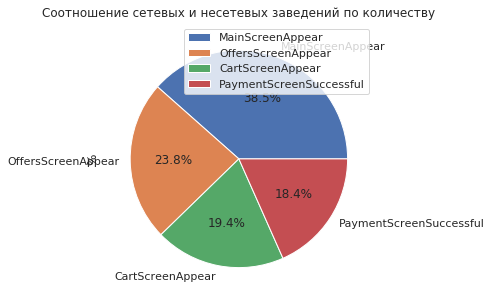

In [26]:
# Визуализируем ввиде диаграммы
df_events.plot( y='%', kind = 'pie', autopct='%1.1f%%', figsize=(5, 5))
plt.title('Соотношение сетевых и несетевых заведений по количеству')

#### Судя по всему, события складываются в воронку продаж. Самое популярное событие - показ главного экрана, а самое непопулярное, которое входит в воронку продаж, - показ экрана оплаты

### 3) Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

#### Предположительно, воронка продаж следующая: 
- пользователь видит главныф экран сайта
- пользователь переходит на понравившийся ему товар 
- пользоватеь добавляет товар в корзину и переходит в нее
- пользователь оплачивает заказ

#### Дополнительно имеется событие - обучение. Возможно, пользователя учат работать с сайтом. Но, судя по доле этого события, оно нре является обязательным на сайте. И только 4% пользователей переходят на эту страницу, поэтому она не входит в воронку продаж.

### 4) По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [27]:
#Создадим столбец конверсий и рассчитаем их в цикле
df_events['conversion'] = 0
for i in range(0, len(df_events['%'])):
    if i == 0:
        df_events['conversion'].iloc[i] = 100
    else:
        df_events['conversion'].iloc[i] = round(int(df_events['device_id'].iloc[i]) / int(df_events['device_id'].iloc[i-1]), 2)*100
display(df_events)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,device_id,event_name,%,conversion
event_name,,,,
MainScreenAppear,7419,1,98.5,100.0
OffersScreenAppear,4593,1,61.0,62.0
CartScreenAppear,3734,1,49.6,81.0
PaymentScreenSuccessful,3539,1,47.0,95.0


#### Было подсчитано, какой процент пользователей проходит на каждый из этапов воронки, от предыдущего шага. На экран с предложением проходит 62% пользователей, посмотревших главный экран. На экран с корзиной переходит 81% пользователей. На экран с успешной оплатой переходит 95% пользователей.

### 4) На каком шаге теряете больше всего пользователей?

#### К оплате переходит 95% пользователей от предыдущего шага, а вот к экрану с предложением проходит только 62% пользователей. Возможно главный экран сайта не самый удобный для пользователей, или имеются другие проблемы. Наименее популярным событием в воронке продаж,как и следовало ожидать, событие перехода к оплате. Но если смотреть на конверсию, то большой процент пользователей теряется при переходе от главного экрана к эклану с предложением.

### 5) Какая доля пользователей доходит от первого события до оплаты?

In [28]:
print('До оплаты доходит', round(df_events['device_id'].iloc[3]/df_events['device_id'].iloc[0], 2)*100, '% пользователей')

До оплаты доходит 48.0 % пользователей


## Шаг 5. Изучите результаты эксперимента

### 1) Сколько пользователей в каждой экспериментальной группе?

In [29]:
#Сделаем сводную таблицу с количествои пользователей на каждую группу
df_new_data_groups = df_new_data.pivot_table(index='experiment_id',values='device_id',aggfunc='nunique')
display(df_new_data_groups)

,device_id,experiment_id
experiment_id,,
246,2484,1
247,2513,1
248,2537,1


#### В 246 группе 2484 пользователя, в 247 группе 2513 пользователей, в группе 248, с увеличенными шрифтами, 2537 пользователей.

### 2) Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

### 3) Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

In [30]:
#Сделам таблицу с числом уникальных пользователей по событиям и контрольным группам
df_voronka = df_new_data.pivot_table(index='experiment_id',columns = 'event_name', values='device_id',aggfunc='nunique')
del df_voronka['Tutorial']
df_voronka['Total'] = [df_new_data_groups['device_id'][0], df_new_data_groups['device_id'][1], df_new_data_groups['device_id'][2]]
display(df_voronka)

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Total
experiment_id,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537


In [31]:
# Напишем функцию для проверки гипотез
def return_hypothesis_test (success, trials, alpha):
    # пропорция успехов в первой группе:
    p1 = success[0] / trials[0]
    # пропорция успехов во второй группе:
    p2 = success[1] / trials[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (trials[0] + trials[1])
    # разница пропорций в датасетах
    difference = p1 - p2
 
    z_value = difference / mth.sqrt(p_combined *(1-p_combined) * (1/trials[0] + 1/trials[1]))
    
    distr = st.norm(0, 1) 
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        print('')
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

In [32]:
# Напишем функцию, которая на вход получает порядковый номер группы в таблице и параметр альфа, и возвращает результаты проверки гипотез
def automation (group1, group2, alpha):
    alpha_test = alpha
    count_users = ([df_voronka['Total'][group1], df_voronka['Total'][group2]])
    count_MainScreenAppear = ([df_voronka['MainScreenAppear'][group1], df_voronka['MainScreenAppear'][group2]])
    count_OffersScreenAppear = ([df_voronka['OffersScreenAppear'][group1], df_voronka['OffersScreenAppear'][group2]])
    count_CartScreenAppear = ([df_voronka['CartScreenAppear'][group1], df_voronka['CartScreenAppear'][group2]])
    count_PaymentScreenSuccessful = ([df_voronka['PaymentScreenSuccessful'][group1], df_voronka['PaymentScreenSuccessful'][group2]])
    
    print('Результаты теста по долям count_users и count_MainScreenAppear для групп')
    return_hypothesis_test(count_MainScreenAppear, count_users, alpha_test)
    
    print('Результаты теста по долям count_OffersScreenAppear и count_users для групп')
    return_hypothesis_test(count_OffersScreenAppear, count_users, alpha_test)
    
    print('Результаты теста по долям count_users и count_CartScreenAppear для групп')
    return_hypothesis_test(count_CartScreenAppear, count_users, alpha_test)
    
    print('Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп')
    return_hypothesis_test(count_PaymentScreenSuccessful, count_users, alpha_test)

#### Нулевая гиптеза: Доли в двух выборках равны
#### Альтернративная гипотеза: Доли в двух выборках не равны

In [33]:
# Сделаем проверку контрольных групп А/A
automation (0, 1, 0.1)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



#### Как видно из проверги гипотез о равенстве долей, нет оснований считать контрольные выборки групп 246 и 247 разными. Равные доли говорят о том, что контрольные группы выбраны верны.
#### Самым популярным событием, как и ожидалось, становится показ главного экрана сайта. С этого и начинается воронка продаж.

### 4) Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

In [34]:
#Соединим две контрольные группы в группу 249
df_voronka.loc['249'] = [df_voronka['CartScreenAppear'][0]+df_voronka['CartScreenAppear'][1] , df_voronka['MainScreenAppear'][0]+df_voronka['MainScreenAppear'][1], df_voronka['OffersScreenAppear'][0]+df_voronka['OffersScreenAppear'][1], df_voronka['PaymentScreenSuccessful'][0]+df_voronka['PaymentScreenSuccessful'][1], df_voronka['Total'][0]+df_voronka['Total'][1]]
display(df_voronka)

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Total
experiment_id,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537
249,2504,4926,3062,2358,4997


In [35]:
# Сделаем проверку групп А1/B (246 и 248)
automation (0, 2, 0.1)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.07842923237520116
Отвергаем нулевую гипотезу: между долями есть значимая разница

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [36]:
print('В 246-ой контрольной группе', round(df_voronka['CartScreenAppear'].iloc[0]/df_voronka['Total'].iloc[1], 2)*100, '% пользователей переходит к оплате')
print('В 248-ой группе с измененными шрифтами', round(df_voronka['CartScreenAppear'].iloc[2]/df_voronka['Total'].iloc[2], 2)*100, '% пользователей переходит к оплате')

В 246-ой контрольной группе 50.0 % пользователей переходит к оплате
В 248-ой группе с измененными шрифтами 48.0 % пользователей переходит к оплате


In [37]:
# Сделаем проверку групп А2/B (247 и 248)
automation (1, 2, 0.1)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [38]:
# Сделаем проверку групп А/B (249 и 248)
automation (3, 2, 0.1)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



#### Между первой контрольной группой (246) и группой с измененными шрифтами (248) значимых различий нет. А вот междц группами 246 и 248 есть значимая разница в доле пользоватей, перешедших к странице корзины. У группы с измененными шрифтами процент перешедших к корзине 48% <  50% перешедших к корзине в контрольных группах.Значимой разницы в переходах объединенной контрольной группы с 248-ой группой нет.

### 5) Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

#### Сделаем проверку гипотез между группами при уровне значимости 0.05

In [39]:
# Сделаем проверку групп А1/A2 (246 и 247)
automation (0, 1, 0.05)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [40]:
# Сделаем проверку групп А1/B (246 и 248)
automation (0, 2, 0.05)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [41]:
# Сделаем проверку групп А2/B (247 и 248)
automation (1, 2, 0.05)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [42]:
# Сделаем проверку групп А/B (249 и 248)
automation (2, 3, 0.05)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



#### При измепнении уровня значимости на 0.05, нулевая гипотеза не отбрасывается уже ни при каких тестах. Доли во всех выборках равны. Различий между контрольными группами и тестовой нет.

# Выводы

- В датасете имеются столбцы с названием события, ID пользователя, временем события и номером экспериментальной группы. Дата записана в неправильном формате. Видны такие события: 'Появление главного экрана', 'Появление экрана оплаты' и т д. События являются частью воронки продаж на сайте. В таблице были удалены дубликаты, откорректированы типы данных, добавлен столбец с данной. Пропуски в таблице отсутствуют
- В логе есть 5 событий, по убыванию их популярности: показ пользователю главного экрана, показ экрана с предложением, показ экрана корзины, показ экрана с подтверждением оплаты, показ обучения. В логе всего 7551 пользователь. В среднем на пользователя приходится 32 события, однако это число завышено из за больших выбросов. Чаще всего на пользователей приходится 0-30 событий. 
- До 01.08.201 совершается очень мало событий. Скорее всего как раз с этой даты все данные доехали, и можно оценивать результаты экспериментов. После удаления ранних данных были потеряно 2826 событий, что составляет около 1% от общего числа, 5 пользователей.
- По 7.7-8к событий приходится на каждую эксперименальную группу.
- Cобытия складываются в воронку продаж. Самое популярное событие - показ главного экрана, а самое непопулярное, которое входит в воронку продаж, - показ экрана оплаты. Предположительно, воронка продаж следующая:
- пользователь видит главныф экран сайта
- пользователь переходит на понравившийся ему товар
- пользоватеь добавляет товар в корзину и переходит в нее
- пользователь оплачивает заказ
- Дополнительно имеется событие - обучение. Возможно, пользователя учат работать с сайтом. Но, судя по доле этого события, оно нре является обязательным на сайте. И только 4% пользователей переходят на эту страницу, поэтому она не входит в воронку продаж.
- Было подсчитано, какой процент пользователей проходит на каждый из этапов воронки, от предыдущего шага. На экран с предложением проходит 62% пользователей, посмотревших главный экран. На экран с корзиной переходит 81% пользователей. На экран с успешной оплатой переходит 95% пользователей. К оплате переходит 95% пользователей от предыдущего шага, а вот к экрану с предложением проходит только 62% пользователей. От показа главного экрана до тоговой оплаты доходит 48 % пользователей.
- В 246 группе 2484 пользователя, в 247 группе 2513 пользователей, в группе 248, с увеличенными шрифтами, 2537 пользователей. Как видно из проверги гипотез о равенстве долей, нет оснований считать контрольные выборки групп 246 и 247 разными.Самым популярным событием, как и ожидалось, становится показ главного экрана сайта. С этого и начинается воронка продаж.
- При уровне статистической значимости 0.1, между второй контрольной группой (247) и группой с измененными шрифтами (248) значимых различий нет, так и нет разницы между тестовой группой и объеиненной контрольной. А вот между группами 246 и 248 есть значимая разница в доле пользоватей, перешедших к корзине.  У группы с измененными шрифтами процент перешедших к оплате 48% < 50% перешедших к оплате в первой контролной группе.
- При измепнении уровня значимости на 0.05, значимой разницы между тестовой группой и всеми контрольными группами при всех событиях нет.
- Для определения уровня значисти лучше проводить компьютерный анализ. Для альфа 0.1 контрольная группа показала себя лучше тестовой для события перехода на страницу корзины. В остальных событиях значимой разницы между группами нет. При уменьшении альфа значительной разницы между группами нет ни для каких событий. Можно сделать вывод, что текст на сайте менять не нужно. В лучшем случае конверсия не изменится. А доля перешедших к корзине пользователей может упасть.